# Conditional Probability Analysis

### Import Data

In [240]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from copy import deepcopy

In [241]:
sim_path = '../../results/synth_classification_fixed_dataset_and_samples/19-05-2023-16:04'


In [242]:
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

runs_dirs = get_immediate_subdirectories(sim_path)

In [243]:
# runs_dirs = ['2']

In [244]:
true_conditional = {}
true_input = {}
estimated_input = {}
pre_AL_conditional = {}
concept_list_dict = {}
metadata = {}

uncertainty_spreading_conditional = {}
first_K_sampling_conditional = {}
random_sampling_conditional = {}
label_spreading_conditional = {}

rs_selected_samples = {}
us_selected_samples = {}
ls_selected_samples = {}

STRATEGIES = [
    "RandomSampling",
    "LabelSpreading"
]

for run in runs_dirs:

    with open(sim_path + '/'+ run +'/metadata.json', 'r') as f:
        metadata[run] = json.load(f)

    run_path = sim_path + '/' + run + '/'

    concept_list_dict[run] = []
    for n in range(metadata[run]['n_concepts']):

        # noinspection PyTypeChecker
        concept_list_dict[run].append(pd.read_csv(
            filepath_or_buffer=run_path + 'concept_' + str(n) + '.csv',
            dtype='str'
        ).astype('float64'))

    true_conditional[run] = pd.read_csv(
        filepath_or_buffer=run_path + 'true_conditional.csv',
        dtype='str'
    ).astype('float64')

    true_input[run] = pd.read_csv(
        filepath_or_buffer=run_path + 'true_input.csv',
        dtype='str'
    ).astype('float64')

    pre_AL_conditional[run] = pd.read_csv(
        filepath_or_buffer=run_path + 'pre_AL_conditional.csv',
        dtype='str'
    ).astype('float64')

    estimated_input[run] = pd.read_csv(
        filepath_or_buffer=run_path + 'estimated_input.csv',
        dtype='str'
    ).astype('float64')

    uncertainty_spreading_conditional[run] = {}
    first_K_sampling_conditional[run] = {}
    random_sampling_conditional[run] = {}
    label_spreading_conditional[run] = {}
    for strategy in STRATEGIES:

        strategy_path = run_path + strategy

        if strategy == "RandomSampling":

           # noinspection PyTypeChecker
           rs_selected_samples[run] = pd.read_csv(
               filepath_or_buffer=strategy_path + '/' + 'selected_samples.csv',
               dtype='str'
           ).astype('float64')

        elif strategy == "UncertaintySpreading":

            # noinspection PyTypeChecker
            us_selected_samples[run] = pd.read_csv(
                filepath_or_buffer=strategy_path + '/' + 'selected_samples.csv',
                dtype='str'
           ).astype('float64')

        elif strategy == "LabelSpreading":
            # noinspection PyTypeChecker
            ls_selected_samples[run] = pd.read_csv(
                filepath_or_buffer=strategy_path + '/' + 'selected_samples.csv',
                dtype='str'
           ).astype('float64')

        for n in range(metadata[run]['n_samples']):
            n_sample = n + 1

            sample_path = strategy_path + '/' + str(n_sample) + '_samples.csv'

            if strategy == "RandomSampling":
                random_sampling_conditional[run][n_sample] = pd.read_csv(
                    filepath_or_buffer=sample_path,
                    dtype='str'
                ).astype('float64')

            elif strategy == "UncertaintySpreading":
                uncertainty_spreading_conditional[run][n_sample] = pd.read_csv(
                    filepath_or_buffer=sample_path,
                    dtype='str'
                ).astype('float64')

            elif strategy == "FirstKSampling":
                first_K_sampling_conditional[run][n_sample] = pd.read_csv(
                    filepath_or_buffer=sample_path,
                    dtype='str'
                ).astype('float64')

            elif strategy == "LabelSpreading":
                label_spreading_conditional[run][n_sample] = pd.read_csv(
                    filepath_or_buffer=sample_path,
                    dtype='str'
                ).astype('float64')


### Plot Concepts

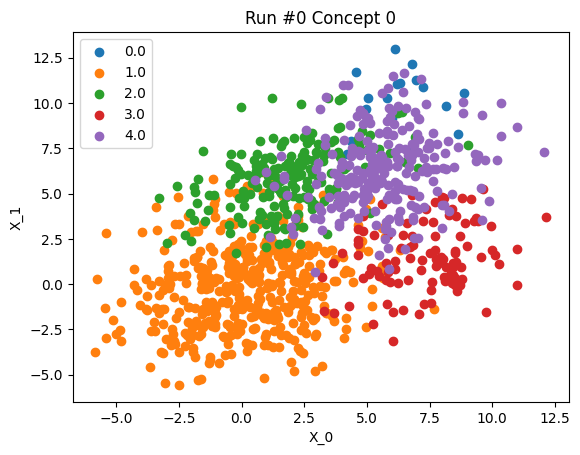

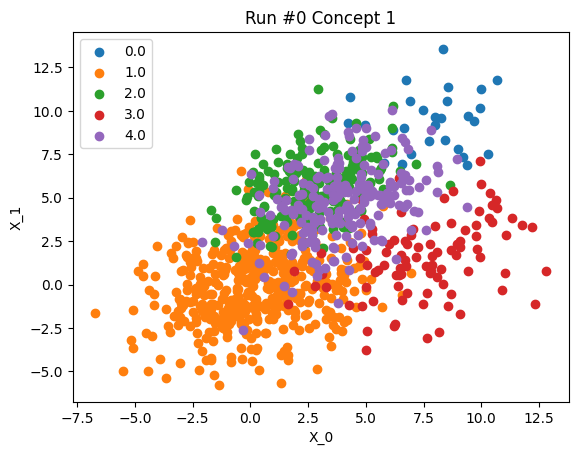

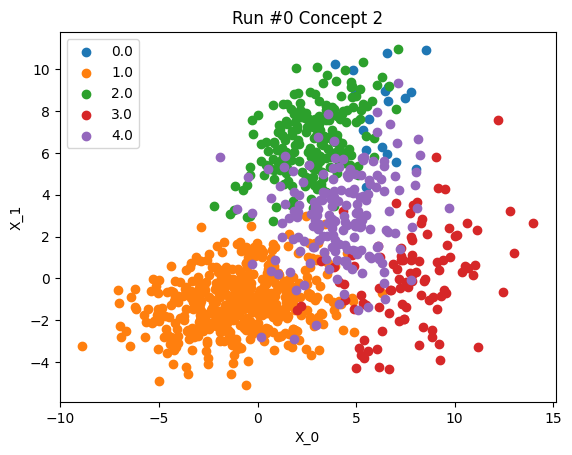

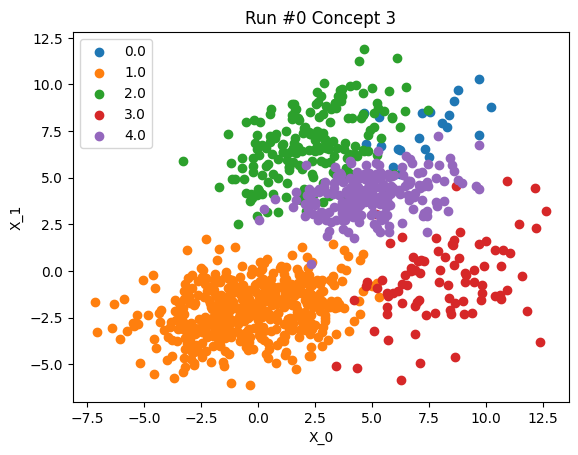

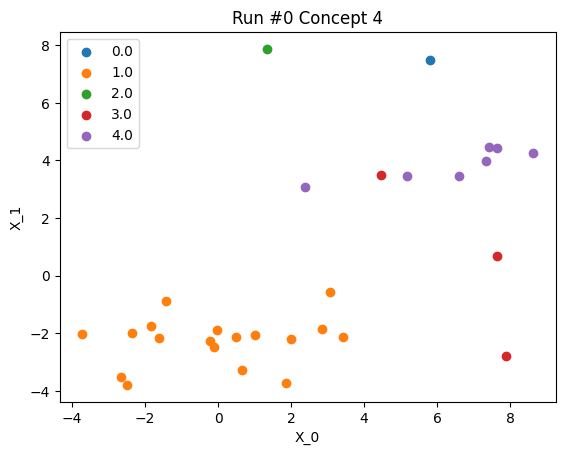

In [245]:
for (run, concept_list) in concept_list_dict.items():
    for index,concept in enumerate(concept_list):
        classes_groups = concept.groupby('y_0')

        fig, ax = plt.subplots()
        for i, (label, group) in enumerate(classes_groups):
            ax.scatter(group['X_0'], group['X_1'],
                    label=label)
        plt.xlabel('X_0')
        plt.ylabel('X_1')
        ax.legend()
        plt.title('Run #' + str(run) + ' Concept ' + str(index))
        plt.show()

### Computing MAE (conditional)

In [246]:
mae_pre = [mean_absolute_error(true_conditional[run], pre_AL_conditional[run]) for run in runs_dirs]

mae_pre = np.average(mae_pre)
mae_pre

0.08011789557498152

In [247]:
mae_rs = {}
for run in random_sampling_conditional.keys():
    mae_rs[run] = []
    for key in random_sampling_conditional[run].keys():
        mae_rs[run].append(mean_absolute_error(true_conditional[run], random_sampling_conditional[run][key]))

In [248]:
mae_us = {}
for run in uncertainty_spreading_conditional.keys():
    mae_us[run] = []
    for key in uncertainty_spreading_conditional[run].keys():
        mae_us[run].append(mean_absolute_error(true_conditional[run], uncertainty_spreading_conditional[run][key]))

In [249]:
mae_ls = {}
for run in label_spreading_conditional.keys():
    mae_ls[run] = []
    for key in label_spreading_conditional[run].keys():
        mae_ls[run].append(mean_absolute_error(
            true_conditional[run],
            label_spreading_conditional[run][key]
        ))

In [250]:
mae_rs_mean = np.mean(a=list(mae_rs.values()), axis=0)
mae_us_mean = np.mean(a=list(mae_us.values()), axis=0)
mae_ls_mean = np.mean(a=list(mae_ls.values()), axis=0)

### Plot Results (conditional)

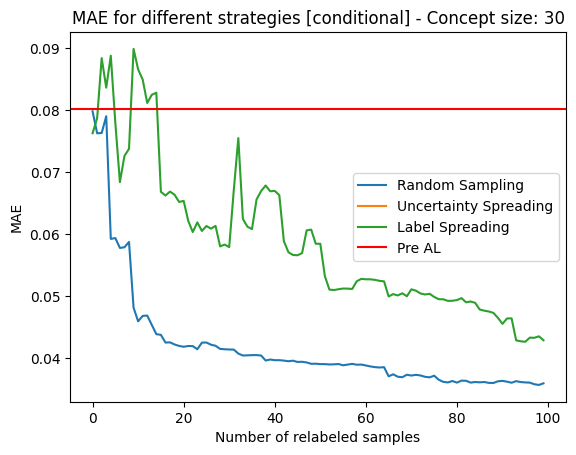

In [251]:
# create a new figure and axis object
fig, ax = plt.subplots()

# plot the MAE values for each model as a line
ax.plot(list(range(len(mae_rs_mean))), list(mae_rs_mean), label='Random Sampling')
ax.plot(list(range(len(mae_us_mean))),list(mae_us_mean), label='Uncertainty Spreading')
ax.plot(list(range(len(mae_ls_mean))),list(mae_ls_mean), label='Label Spreading')
plt.axhline(y=mae_pre, color='r', linestyle='-', label='Pre AL')

# add a legend to the plot
ax.legend()

# set the x-axis label
ax.set_xlabel('Number of relabeled samples')

# set the y-axis label
ax.set_ylabel('MAE')

# set the title of the plot
ax.set_title('MAE for different strategies [conditional] - Concept size: ' + str(metadata[runs_dirs[0]]['last_concept_size']))

# display the plot


plt.show()

### Computing MAE (joint)

In [252]:
mae_pre = [mean_absolute_error(true_conditional[run] * estimated_input[run], pre_AL_conditional[run] * estimated_input[run]) for run in runs_dirs]

mae_pre = np.average(mae_pre)
mae_pre

1.535195122659131e-06

In [253]:
mae_rs = {}
for run in random_sampling_conditional.keys():
    mae_rs[run] = []
    for key in random_sampling_conditional[run].keys():
        mae_rs[run].append(mean_absolute_error(true_conditional[run] * estimated_input[run], random_sampling_conditional[run][key] * estimated_input[run]))

In [254]:
mae_us = {}
for run in uncertainty_spreading_conditional.keys():
    mae_us[run] = []
    for key in uncertainty_spreading_conditional[run].keys():
        mae_us[run].append(mean_absolute_error(true_conditional[run] * estimated_input[run], uncertainty_spreading_conditional[run][key] * estimated_input[run]))

In [255]:
mae_ls = {}
for run in label_spreading_conditional.keys():
    mae_ls[run] = []
    for key in label_spreading_conditional[run].keys():
        mae_ls[run].append(mean_absolute_error(
            true_conditional[run] * estimated_input[run],
            label_spreading_conditional[run][key] * estimated_input[run]
        ))

In [256]:
mae_rs_mean = np.mean(a=list(mae_rs.values()), axis=0)
mae_us_mean = np.mean(a=list(mae_us.values()), axis=0)
mae_ls_mean = np.mean(a=list(mae_ls.values()), axis=0)

### Plot Results (joint)

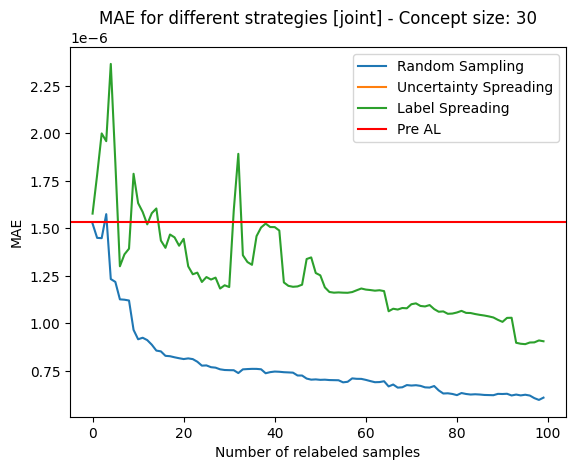

In [257]:
# create a new figure and axis object
fig, ax = plt.subplots()

# plot the MAE values for each model as a line
ax.plot(list(range(len(mae_rs_mean))), list(mae_rs_mean), label='Random Sampling')
ax.plot(list(range(len(mae_us_mean))),list(mae_us_mean), label='Uncertainty Spreading')
ax.plot(list(range(len(mae_ls_mean))),list(mae_ls_mean), label='Label Spreading')
plt.axhline(y=mae_pre, color='r', linestyle='-', label='Pre AL')

# add a legend to the plot
ax.legend()

# set the x-axis label
ax.set_xlabel('Number of relabeled samples')

# set the y-axis label
ax.set_ylabel('MAE')

# set the title of the plot
ax.set_title('MAE for different strategies [joint] - Concept size: ' + str(metadata[runs_dirs[0]]['last_concept_size']))

# display the plot
plt.show()

### Plot Selected Samples

In [258]:
pd.set_option('display.max_rows', None)

In [259]:
unmatched_samples = deepcopy(rs_selected_samples)

In [260]:
for (run, concept_list) in concept_list_dict.items():
    for concept in concept_list:
        unmatched_samples[run] = pd.merge(unmatched_samples[run], concept, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [261]:
# useful to know how many samples have been relabeled with a different label
# from the original one when applying change to the select samples methods
len(unmatched_samples)

1

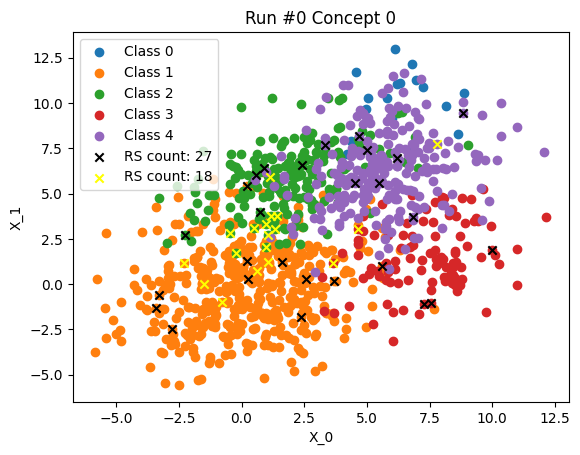

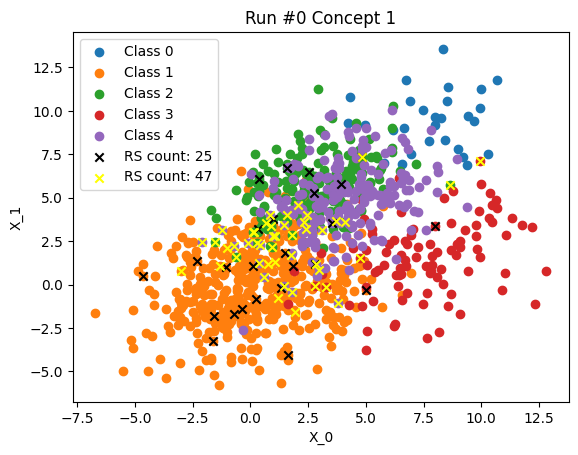

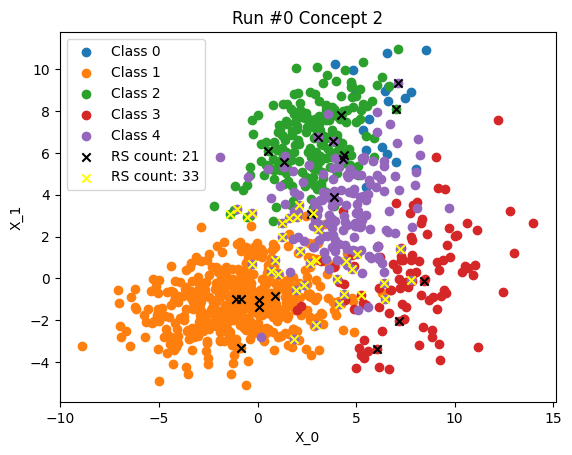

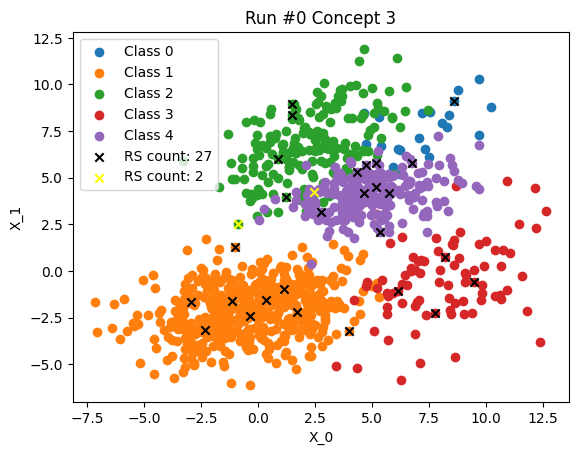

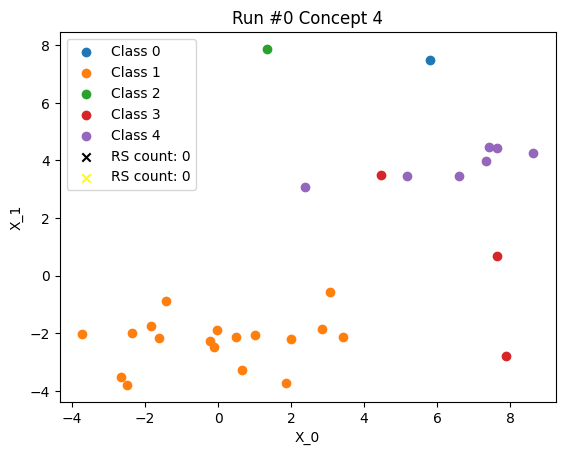

In [262]:
for (run, concept_list) in concept_list_dict.items():
    for index,concept in enumerate(concept_list):
        classes_groups = concept.groupby('y_0')

        fig, ax = plt.subplots()
        for i, (label, group) in enumerate(classes_groups):
            ax.scatter(group['X_0'], group['X_1'],
                    label='Class ' + str(int(label)))
        # selected_samples_us = pd.merge(concept, us_selected_samples[run])
        selected_samples_rs = pd.merge(concept, rs_selected_samples[run])
        selected_samples_ls = pd.merge(concept, ls_selected_samples[run])
        # plt.scatter(selected_samples_us['X_0'], selected_samples_us['X_1'], c='red', marker='x', label='US count: ' + str(selected_samples_us.value_counts().count()))
        plt.scatter(selected_samples_rs['X_0'], selected_samples_rs['X_1'], c='black', marker='x', label='RS count: ' + str(selected_samples_rs.value_counts().count()))
        plt.scatter(selected_samples_ls['X_0'], selected_samples_ls['X_1'], c='yellow', marker='x', label='LS count: ' + str(selected_samples_ls.value_counts().count()))
        plt.xlabel('X_0')
        plt.ylabel('X_1')
        ax.legend()
        plt.title('Run #' + str(run) + ' Concept ' + str(index))
        plt.show()
